# 机器学习工程师纳米学位
## 强化学习
## 项目 4: 训练智能出租车学会驾驶

欢迎来到机器学习工程师纳米学位的第四个项目！在这个notebook文件中，模板代码已经提供给你，有助于你对*智能出租车*的分析和实现学习算法。你无须改动已包含的代码，除非另有要求。 你需要回答notebook文件中给出的与项目或可视化相关的问题。每一个你要回答的问题前都会冠以**'问题 X'**。仔细阅读每个问题，并在后面**'回答'**文本框内给出完整的回答。你提交的项目会根据你对于每个问题的回答以及提交的`agent.py`的实现来进行评分。 

>**提示：** Code 和 Markdown 单元格可通过 **Shift + Enter** 快捷键来执行。此外，Markdown可以通过双击进入编辑模式。

-----

## 开始
在这个项目中，你将构建一个优化的Q-Learning驾驶代理程序，它会操纵*智能出租车* 通过它的周边环境到达目的地。因为人们期望*智能出租车*要将乘客从一个地方载到另一个地方，驾驶代理程序会以两个非常重要的指标来评价：**安全性**和**可靠性**。驾驶代理程序在红灯亮时仍然让*智能出租车*行驶往目的地或者勉强避开事故会被认为是**不安全**的。类似的，驾驶代理程序频繁地不能适时地到达目的地会被认为**不可靠**。最大化驾驶代理程序的**安全性**和**可靠性**保证了*智能出租车*会在交通行业获得长期的地位。

**安全性**和**可靠性**用字母等级来评估，如下：

| 等级 	| 安全性 	| 可靠性 	|
|:-----:	|:------:	|:-----------:	|
|   A+  	| 代理程序没有任何妨害交通的行为，<br/>并且总是能选择正确的行动。| 代理程序在合理时间内到达目的地的次数<br />占行驶次数的100%。 |
|   A   	| 代理程序有很少的轻微妨害交通的行为，<br/>如绿灯时未能移动。| 代理程序在合理时间内到达目的地的次数<br />占行驶次数的90%。 |
|   B   	| 代理程序频繁地有轻微妨害交通行为，<br/>如绿灯时未能移动。| 代理程序在合理时间内到达目的地的次数<br />占行驶次数的80%。 |
|   C   	| 代理程序有至少一次重大的妨害交通行为，<br/>如闯红灯。| 代理程序在合理时间内到达目的地的次数<br />占行驶次数的70%。 |
|   D   	| 代理程序造成了至少一次轻微事故，<br/>如绿灯时在对面有车辆情况下左转。	| 代理程序在合理时间内到达目的地的次数<br />占行驶次数的60%。 |
|   F   	| 代理程序造成了至少一次重大事故，<br/>如有交叉车流时闯红灯。	| 代理程序在合理时间内到达目的地的次数<br />未能达到行驶次数的60%。 |

为了协助评估这些重要的指标，你会需要加载可视化模块的代码，会在之后的项目中用到。运行下面的代码格来导入这个代码，你的分析中会需要它。

In [1]:
# 检查你的Python版本
from sys import version_info
if version_info.major != 2 and version_info.minor != 7:
    raise Exception('请使用Python 2.7来完成此项目')

In [2]:
# Import the visualization code
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

### 了解世界
在开始实现你的驾驶代理程序前，首先需要了解*智能出租车*和驾驶代理程序运行的这个世界（环境）。构建自我学习的代理程序重要的组成部分之一就是了解代理程序的特征，包括代理程序如何运作。原样直接运行`agent.py`代理程序的代码，不需要做任何额外的修改。让结果模拟运行一段时间，以观察各个不同的工作模块。注意在可视化模拟程序（如果启用了），**白色车辆**就是*智能出租车*。

### 问题 1
用几句话，描述在运行默认的`agent.py`代理程序中，你在模拟程序里观察到了什么。一些你可以考虑的情况：
- *在模拟过程中，智能出租车究竟移动了吗？*
- *驾驶代理程序获得了什么样的奖励？*
- *交通灯的颜色改变是如何影响奖励的？*

**提示：** 从顶层的`/smartcab/`目录（这个notebook所在的地方），运行命令
```bash
'python smartcab/agent.py'
```

**回答：**

- 在模拟过程中，智能出租车并没有移动，始终待在原地。每一个Trial都会随机选取白色出租车的初始位置，并持续125个回合就结束。
- 驾驶代理程序获得的奖励有正有负，根据当时交通情况和出租车的行为所决定，并且奖励的取值在一定范围内具有随机性。
- 交通灯的颜色改变和出租车采取不同行动的奖励如下：

操作|属性|奖励取值范围
----|----|----|----
Agent idled at red light|正确|(1, 4)
Agent idled at green light with oncoming traffic|正确|(0, 2)
Agent idled at green light without oncoming traffic|错误|(-3, -6)

### 理解代码
除了要了解世界之外，还需要理解掌管世界、模拟程序等等如何运作的代码本身。如果一点也不去探索一下*“隐藏”*的器件，就试着去创建一个驾驶代理程序会很难。在顶层的`/smartcab/`的目录下，有两个文件夹：`/logs/` （之后会用到）和`/smartcab/`。打开`/smartcab/`文件夹，探索每个下面的Python文件，然后回答下面的问题。

### 问题 2
- *在*`agent.py`* Python文件里，选择 3 个可以设定的 flag，并描述他们如何改变模拟程序的。*
- *在*`environment.py`* Python文件里，当代理程序执行一个行动时，调用哪个Environment类的函数？*
- *在*`simulator.py`* Python 文件里，*`'render_text()'`*函数和*`'render()'`*函数之间的区别是什么?*
- *在*`planner.py`* Python文件里，*`'next_waypoint()`* 函数会先考虑南北方向还是东西方向?*

**回答：**

- verbose: 输出更详细的log开关。打开后，会显示每一步的具体运行状态。比如：

Environment.step(): t = 0
Environment.act() [POST]: location: (2, 3), heading: (1, 0), action: None, rewar
d: 1.55708291923
Environment.act(): Step data: {'inputs': {'light': 'green', 'oncoming': 'left',
'right': 'left', 'left': None}, 'violation': 0, 'light': 'green', 'state': None,
 'deadline': 35, 't': 0, 'action': None, 'reward': 1.557082919225834, 'waypoint'
: 'left'}
!! Agent state not been updated!
Agent idled at a green light with oncoming traffic. (rewarded 1.56)
Agent not enforced to meet deadline.

- num_dummies: 设定地图上其他车辆个数。数值越大，交通情况越复杂。但是不能超过地图所能容纳的总节点个数。
- grid_size: 设定地图尺寸，形如 (x, y)，其中x表示路口的列数，y表示路口的行数。

- 调用了act(self, agent, action)函数

- render_text()负责往console（非GUI) 里输出agent的运行情况信息，而 render() 则负责在GUI界面上显示agent的运行情况的文字和图像信息。

- next_waypoint()函数会先考虑东西向。

-----
## 实现一个基本的驾驶代理程序

创建一个优化Q-Learning的驾驶代理程序的第一步，是让代理程序确实地执行有效的行动。在这个情况下，一个有效的行动是`None`（不做任何行动）、`'Left'`（左转）、`'Right'`（右转）或者`'Forward'`（前进）。作为你的第一个实现，到`'choose_action()'`代理程序函数，使驾驶代理程序随机选择其中的一个动作。注意你会访问到几个类的成员变量，它们有助于你编写这个功能，比如`'self.learning'`和`'self.valid_actions'`。实现后，运行几次代理程序文件和模拟程序来确认你的驾驶代理程序每步都执行随机的动作。

### 基本代理程序模拟结果
要从最初的模拟程序获得结果，你需要调整下面的标志：
- `'enforce_deadline'` - 将此标志设定为`True`来强制驾驶代理程序捕获它是否在合理时间内到达目的地。
- `'update_delay'` - 将此标志设定为较小数值（比如`0.01`）来减少每次试验中每步之间的时间。
- `'log_metrics'` - 将此标志设定为`True`将模拟结果记录为在`/logs/`目录下的`.csv`文件。
- `'n_test'` - 将此标志设定为`'10'`则执行10次测试试验。

可选的，你还可以通过将`'display'`标志设定为`False`来禁用可视化模拟（可以使得试验跑得更快）。调试时，设定的标志会返回到他们的默认设定。重要的是要理解每个标志以及它们如何影响到模拟。

你成功完成了最初的模拟后（有20个训练试验和10个测试试验），运行下面的代码单元格来使结果可视化。注意运行同样的模拟时，日志文件会被覆写，所以留意被载入的日志文件！在 projects/smartcab 下运行 agent.py 文件。

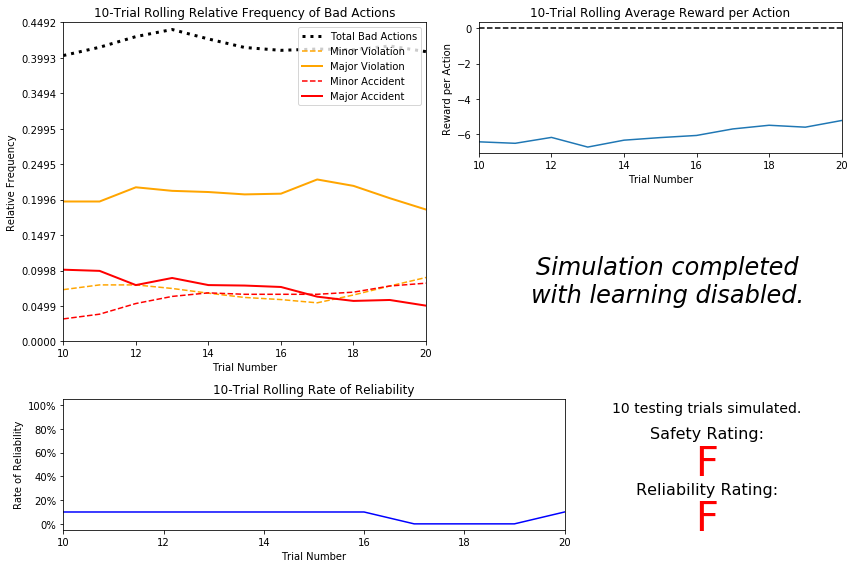

In [7]:
# Load the 'sim_no-learning' log file from the initial simulation results
vs.plot_trials('sim_no-learning.csv')

### 问题 3
利用上面的从你初始模拟中得到的可视化结果，给出关于驾驶代理程序的分析和若干观察。确保对于可视化结果上的每个面板你至少给出一条观察结果。你可以考虑的一些情况：
- *驾驶代理程序多频繁地做出不良决策？有多少不良决策造成了事故？*
- *假定代理程序是随机驾驶，那么可靠率是否合理？*
- *代理程序对于它的行动会获得什么样的奖励？奖励是否表明了它收到严重的惩罚？*
- *随着试验数增加，结果输出是否有重大变化？*
- *这个智能出租车对于乘客来说，会被人为是安全的且/或可靠的吗？为什么或者为什么不？*

**答案：**

- 从不良决策频率图表（Frequency of Bad Actions）中可以看到，不良决策（黑色虚线）的出现频率大概在37%至43%之间。其中造成事故的不良决策（红色虚线及红色实线）出现频率为大概在10%左右。
- 从可靠性图表（Rate of Reliability）中可以看到，每轮的可靠性基本上都保持在18%左右。作为随机驾驶来说是可以接受的。
- 从驾驶操作平均奖励图表（Average Rewars per Actions）中可以看到，平均的奖励值大概都在 -6 左右。基本上奖励值负的越厉害惩罚越严重.
- 基本上没有特重大的变化，经过多次尝试，可靠性和安全性会随着训练次数的增加随机的波动，但是并不具有统一的改善或者恶化趋势。
- 不可能被认为是安全或可靠的。因为评分都是F，既不安全也不可靠。安全性上，由于经常出现重大交通事故，因此很不安全。可靠性上，由于根本就是随机驾驶，能抵达终点的可能性很低。本质上，小车没有学习能力。

-----
## 通知驾驶代理程序
创建一个优化Q-Learning的驾驶代理程序的第二步，是定义一系列代理程序会在环境中发生的状态。根据输入、感知数据和驾驶代理程序可用的变量，可以为代理程序定义一系列状态，使它最终可以*学习*在一个状态下它需要执行哪个动作。对于每个状态的`'如果这个处于这个状态就那个行动'`的状况称为**策略**，就是最终驾驶代理程序要学习的。没有定义状态，驾驶代理程序就不会明白哪个动作是最优的——或者甚至不会明白它要关注哪个环境变量和条件！

### 识别状态
查看`'build_state()'`代理程序函数，它显示驾驶代理函数可以从环境中获得下列数据：
- `'waypoint'`，*智能出租车*去向目的地应该行驶的方向，它是*智能出租车*车头方向的相对值。
- `'inputs'`，*智能出租车*的感知器数据。它包括  
  - `'light'`，交通灯颜色。
  - `'left'`，*智能出租车*左侧车辆的目的方向。如果没有车辆，则返回`None`。
  - `'right'`，*智能出租车*右侧车辆的目的方向。如果没有车辆，则返回`None`。
  - `'oncoming'`，*智能出租车*交叉方向车辆的目的方向。如果没有车辆，则返回`None`。
- `'deadline'`，*智能出租车*在时间之内到达目的地还所需的剩余动作数目。

### 问题 4
*代理程序的哪些可用特征与学习**安全性**和**效率**相关性最高？你为什么认为这些特征适合在环境中对**智能出租车**建模？如果你没有选择某些特征，放弃他们的原因是什么？*

**回答：**

**1.驾驶等级**

environment.py 中给出了对小车驾驶行为的评分等级。  

- 0: Action okay  
- 1: Minor traffic violation  
- 2: Major traffic violation  
- 3: Minor traffic violation causing an accident  
- 4: Major traffic violation causing an accident  

可以看到，只有0级才表示小车的行为完全合法，其他的四种等级都属于错误的行为。由于错误的行为并不一定造成事故，因此又分为造成事故（3和4）和未造成事故两种情况（1和2）。

**2. 车辆行驶规则**

environment.py 中也给出了专门针对小车的交通规则，以及奖励机制。

```python
# Agent wants to drive forward:
        if action == 'forward':
            if light != 'green': # Running red light
                violation = 2 # Major violation
                if inputs['left'] == 'forward' or inputs['right'] == 'forward': # Cross traffic
                    violation = 4 # Accident
        
        # Agent wants to drive left:
        elif action == 'left':
            if light != 'green': # Running a red light
                violation = 2 # Major violation
                if inputs['left'] == 'forward' or inputs['right'] == 'forward': # Cross traffic
                    violation = 4 # Accident
                elif inputs['oncoming'] == 'right': # Oncoming car turning right
                    violation = 4 # Accident
            else: # Green light
                if inputs['oncoming'] == 'right' or inputs['oncoming'] == 'forward': # Incoming traffic
                    violation = 3 # Accident
                else: # Valid move!
                    heading = (heading[1], -heading[0])

        # Agent wants to drive right:
        elif action == 'right':
            if light != 'green' and inputs['left'] == 'forward': # Cross traffic
                violation = 3 # Accident
            else: # Valid move!
                heading = (-heading[1], heading[0])

        # Agent wants to perform no action:
        elif action == None:
            if light == 'green' and inputs['oncoming'] != 'left': # No oncoming traffic
                violation = 1 # Minor violation
```

总结可得所有合法的驾驶模式如下：

|信号灯 light|行为 action|对向车道情况 oncoming|左侧车道情况 left|右侧车道情况 right|驾驶类别|
|----|----|----|----|----|----|
|绿灯|直行|不用管|不用管|不用管|$\color{green} {\mathbf{0}}$|
|绿灯|左转|有车左转|不用管|不用管|$\color{green} {\mathbf{0}}$|
|绿灯|右转|不用管|不用管|不用管|$\color{green} {\mathbf{0}}$|
|红灯|右转|不用管|有车左转或右转|不用管|	$\color{green} {\mathbf{0}}$|
|红灯|不动|不用管|不用管|不用管|$\color{green} {\mathbf{0}}$|
|绿灯|不动|有车左转|不用管|不用管|$\color{green} {\mathbf{0}}$|

非法驾驶模式如下：

|信号灯 light|行为 action|对向车道情况 oncoming|左侧车道情况 left|右侧车道情况 right|非法驾驶类别|
|----|----|----|----|----|----|
|红灯|直行|无车|无车|无车|$\color{orange} {\mathbf{2}}$|
|红灯|直行|无车|有车直行|有车直行|$\color{red} {\mathbf{4}}$|
|红灯|左转|无车|无车|无车|$\color{orange} {\mathbf{2}}$|
|红灯|左转|无车|无车|有车直行|$\color{red} {\mathbf{4}}$|

**3. 针对其他车辆的交规**

environment.py 中对于Dummy Agent具有单独的行为判定逻辑。与Agent不同的是，所有Dummy Agent已经被限定为不会违反交通规则，只要发现所接收到的导航行为违反交通规则，Dummy Agent就会无条件的保持不动一次。（而Agent则可以自由选择是否要违反交通规则，即使不违反交通规则，也不一定非要通过保持不动来做到。）

比如Dummy Agent的下个导航指令是直行，但是交通灯是红灯，那么它并不会直行，而是保持不动。而Agent如果面对同样情况，则可以选择直行，并获得一个负的奖励值，或者选择右转而不直行等等。

**4. 总结**

根据上面的代码分析，小车所在的世界存在以下假设：
- 所有小车（包括agent和dummy agent）都认为这个世界的其他人都是完美驾驶。
- 相互垂直的路口红绿灯状态始终互斥。相互平行的路口红绿灯状态始终相同。

**5. 特征选择**

- 安全性方面需要选择的相关特征  
  - inputs['light'] 最关键，决定是否会闯红灯。
  - inputs['oncoming'] 决定是否能够绿灯左转。
  - inputs['left'] 决定是否能红灯右转。也决定红灯是直行或左转的严重性。
  - inputs['right'] 决定红灯时直行或左转的非法严重性（是否造成事故）。
- 可靠性方面需要选择的相关特征
  - waypoint 决定了不考虑交通情况的最快的驾驶方向。不选的话，无法确保小车能够到达目的地。
- 不选 deadline 特征
  - 从逻辑上分析，deadline是一个时序随机变量，而且其初始状态也是随机的，与是否安全快速抵达的关系并不大。因为我们已经有了导航，导航告诉我们的是不考虑交通情况下的最短路径，因此我们即使不管deadline，只把握当下的信号灯、交通情况、导航路线，就已经可以做到即安全又可靠的抵达目的地了。所以不选。
  - 从代码实现上分析，由于 environment.py 的 reset() 函数显示deadline的初始值等于初始位置与目的地距离的5倍。因此这个特征的可能状态是地图大小以及初始状态随机决定的。对于目前的地图大小来讲，初始状态下deadline的平均值是24左右，乘上其他几个必备特征的状态数，总状态数就立刻上升至将近3000个。想要遍历这么多状态，对于训练的要求就太高了。所以不选。

### 定义状态空间
当定义一系列代理程序会处于的状态，必需考虑状态空间的*大小*。就是说，如果你期望驾驶代理程序针对每个状态都学习一个**策略**，你会需要对于每一个代理状态都有一个最优的动作。如果所有可能状态的数量非常大，最后会变成这样的状况，驾驶代理程序对于某些状态学不到如何行动，会导致未学习过的决策。例如，考虑用下面的特征定义*智能出租车*的状态的情况：

`('is_raining', 'is_foggy', 'is_red_light', 'turn_left', 'no_traffic', 'previous_turn_left', 'time_of_day')`.
发生如`(False, True, True, True, False, False, '3AM')`的状态的频次如何？没有近乎无限数量的训练，很怀疑代理程序会学到一个合适的动作！

### 问题 5
*如果用你在**问题4**中选择的特征来定义一个状态，状态空间的大小是多少？假定你了解环境以及它是如何模拟的，你觉得经过合理数量的训练之后，代理驾驶能学到一个较好的策略吗？（遇见绝大部分状态都能作出正确决策。）*
**提示：** 考虑特征*组合*来计算状态的总数！

**回答：**

由于问题4里已经分析至少需要5个特征才能比较全面的提供安全性和效率方面的指示，因此可以得到由下表所示的状态空间：

|特征|可能取值个数|可能取值|
|----|----|----|----|
|light|2|red, green|
|oncoming|4|None, forward, left, right|
|left|4|None, forward, left, right|
|right|4|None, forward, left, right|
|waypoint|3|forward, left, right|

其中waypoint是planner给出的最近导航路线，由于是导航，它不可能输出让你不动(None)这个action，因此总取值个数不是4，而是3。

对状态可能取值进行全排列，总状态数是384。  
如果让小车通过训练随机驾驶收集足够多的状态值，覆盖绝大多数状态，那么agent应该能够学到一个较好的驾驶策略。

### 更新驾驶代理程序的状态
要完成你的第二个实现，去到`'build_state()'`代理程序函数。根据你在**问题4**给出的判断，你现在要将`'state'`变量设定为包含所有Q-Learning所需特征的元组。确认你的驾驶代理程序通过运行代理程序文件和模拟会更新它的状态，注意状态是否显示了。如果用了可视化模拟，确认更新的状态和在模拟程序里看到的一致。

**注意：** 观察时记住重置模拟程序的标志到默认设定！

-----
## 实现Q-Learning驾驶代理程序
创建一个优化Q-Learning的驾驶代理程序的第三步，是开始实现Q-Learning自身的功能。Q-Learning的概念相当直接：每个访问的状态，为所有可用的状态-行动配对在Q-table里创建一条记录。然后，当代理程序遇到一个状态并执行了一个动作，基于获得的奖励和设定的相互的更新规则，来更新关联的状态-动作配对的Q-value。当然，Q-Learning还带来其他的收益，如此我们可以让代理程序根据每个可能的状态-动作配对的Q-values，来为每个状态选择*最佳*动作。在这个项目里，你会实现一个*衰减* $\epsilon$ *-贪心* 的Q-learning算法，不含折扣因子。遵从每个代理程序函数的**TODO**下的实现指导。

注意代理程序的属性`self.Q`是一个字典：这就是Q-table的构成。每个状态是`self.Q`字典的键，每个值是另一个字典，包含了*action*和*Q-value*。这里是个样例：

```
{ 'state-1': { 
    'action-1' : Qvalue-1,
    'action-2' : Qvalue-2,
     ...
   },
  'state-2': {
    'action-1' : Qvalue-1,
     ...
   },
   ...
}
```

此外，注意你要求利用一个*衰减*$\epsilon$*（探索）因子*。因此，随着试验的增加，$\epsilon$会向0减小。这是因为，代理程序会从它的行为中学习，然后根据习得的行为行动。而且当$\epsilon$达到特定阈值后（默认阈值为0.01），代理程序被以它所学到的东西来作检测。作为初始的Q-Learning实现，你将实现一个线性衰减$\epsilon$的函数。

### Q-Learning模拟结果
要从最初的Q-learning程序获得结果，你需要调整下面的标志和设置：
- `'enforce_deadline'` - 将此标志设定为`True`来强制驾驶代理程序捕获它是否在合理时间内到达目的地。
- `'update_delay'` - 将此标志设定为较小数值（比如`0.01`）来减少每次试验中每步之间的时间。
- `'log_metrics'` - 将此标志设定为`True`将模拟结果记录为在`/logs/`目录下的`.csv`文件，Q-table存为`.txt`文件。
- `'n_test'` - 将此标志设定为`'10'`则执行10次测试试验。
- `'learning'` - 将此标志设定为`'True'`来告诉驾驶代理使用你的Q-Learning实现。

此外，使用下面的$\epsilon$衰减函数：

$$ \epsilon_{t+1} = \epsilon_{t} - 0.05, \hspace{10px}\textrm{for trial number } t$$

如果你在实施时遇到困难，尝试把`'verbose'`标志设为`True`来调试。调试时，在这里设定的标志会返回到它们的默认设定。重要的是你要理解每个标志做什么并且解释它们怎么影响模拟！

当你成功完成初始的Q-Learning模拟程序后，运行下面代码单元格来使结果可视化。注意当相同的模拟运行时，log文件会被覆写，所以要留意载入的log文件！

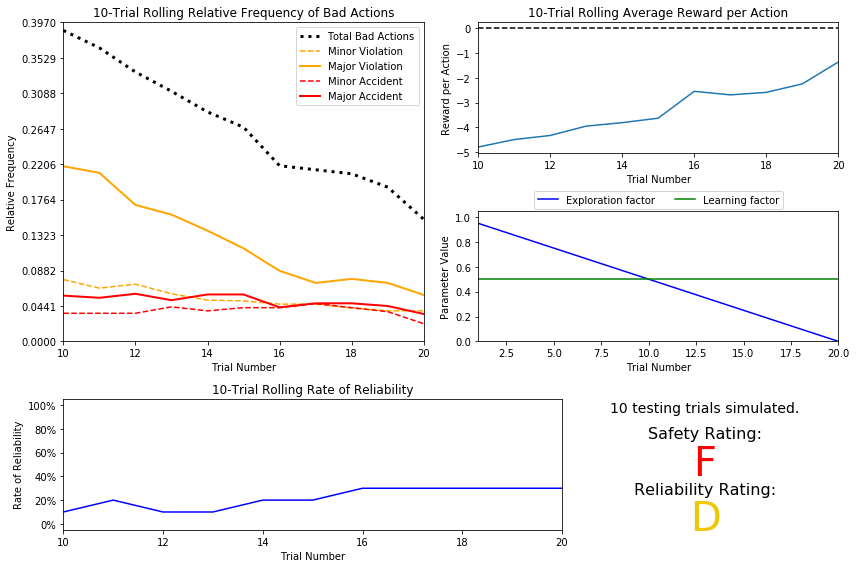

In [8]:
# Load the 'sim_default-learning' file from the default Q-Learning simulation
vs.plot_trials('sim_default-learning.csv')

### 问题 6
利用上面的从你默认的Q-Learning模拟中得到的可视化结果，像在**问题3**那样，给出关于驾驶代理程序的分析和若干观察。注意模拟程序应该也产生了Q-table存在一个文本文件中，可以帮到你观察代理程序的算法。你可以考虑的一些情况：
- *有没有观察到基本驾驶代理程序和默认的Q-Learning代理程序的相似之处？*
- *在测试之前驾驶代理大约需要做多少训练试验？在给定的$\epsilon$ 容忍度下，这个数字是否合理？*
- *你实现的$\epsilon$（探索因子）衰减函数是否准确地在参数面板中显示？*
- *随着试验数增加，不良动作的数目是否减少?平均奖励是否增加？*
- *与初始的驾驶代理程序相比，安全性和可靠性评分怎样？*

**回答：**

- 通过上面的图表可以看到，一开始的Trial的Bad Action占比个数就在30%-40%这个区间，这和问题3中对于不学习的agent的性能是十分相似的。另外通过以下代码同样也可以看到，choose_action()函数中，如果开启学习模式，那么agent在一开始时候的行为，完全等效于关闭学习模式时的随机驾驶状态，根本不考虑next_waypoint()给出的导航路线，于此同时，每次调用action()之后，我们都会通过learn()把当前状态下的操作奖励记录到Q值表里。随着epsilon每次以0.05的步长逐渐减小，进入到第二个if语句里面的可能性越来越小，进入到第二个else的可能性越来越大，也就是说，agent会越来越倾向于直接用Q值表里的最佳操作，而不再倾向于随机探索试错。

```python
if not self.learning:
		    action = random.choice(self.valid_actions)
        else:
            if random.random() < self.epsilon:
                action = random.choice(self.valid_actions)
            else:
                max_Q = max(self.Q[state].values())
                max_candidate = [x for x in self.Q[state] if self.Q[state][x] == max_Q]
                action = random.choice(max_candidate)
```

- 开启学习模式后，simulator.py的代码判断从训练进入测试模式的准则是看epsilon是否小于tolerance。由于步长是0.05，因此epsilon从1降到小于0.05需要20次。也就是说训练次数等于20。通过跟踪 len(self.Q) 值的变化，可以看到在完成20次训练后，Q值表的长度大概能够达到170左右，距离全状态数（384）有50%多的差距。而且实际上Q值表中真正非零的Q值（即已经至少试错过一次的状态-行动组合）只有不到300个，覆盖率只有20%，因此实际上训练的还不够多。

- 是的。可以看到代表epsilon的蓝色直线以恒定斜率从1下降至0。

- 是的。Total bad action个数随试验次数增加，从39%下降至17%，同时平均奖励随实验次数增大而从-5上升至-2。

- 初始的agent无论是安全性还是效率都是最低分（F/F），这是由于agent根本不能从训练中学到任何东西，而仅仅是随机的驾驶，因此很多时候会导致交通事故（安全性差），或者导致根本到不了目的地（可靠性差）。相比之下，目前修改后的agent在经过20轮训练后，Total bad Action的占比从39%下降至17%左右，可靠性略微有些变化（低于20%到高于20%)，平均奖励分数也从-5上升至-2。从评分上看，可靠性从F上升至D，但安全性依然很差。

-----
## 改进Q-Learning驾驶代理程序
创建一个优化Q-Learning的驾驶代理程序的第三步，是执行优化！现在Q-Learning算法已经实现并且驾驶代理程序已经成功学习了，需要调整设定、调节参数让驾驶代理程序学习**安全性**和**效率**。通常这一步需要很多试验和错误，因为某些设定必定会造成更糟糕的学习。要记住的一件事是学习的行为本身和需要的时间：理论上，我们可以允许代理程序用非常非常长的时间来学习；然而，Q-Learning另一个目的是*将没有习得行为的试验试验变为有习得行为的行动*。例如，训练中总让代理程序执行随机动作（如果$\epsilon = 1$并且永不衰减）当然可以使它*学习*，但是不会让它*行动*。当改进你的Q-Learning实现时，要考虑做一个特定的调整的意义，以及它是否逻辑上是否合理。

### 改进Q-Learning的模拟结果
要从最初的Q-learning程序获得结果，你需要调整下面的标志和设置：
- `'enforce_deadline'` - 将此标志设定为`True`来强制驾驶代理程序捕获它是否在合理时间内到达目的地。
- `'update_delay'` - 将此标志设定为较小数值（比如`0.01`）来减少每次试验中每步之间的时间。
- `'log_metrics'` - 将此标志设定为`True`将模拟结果记录为在`/logs/`目录下的`.csv`文件，Q-table存为`.txt`文件。
- `'learning'` - 将此标志设定为`'True'`来告诉驾驶代理使用你的Q-Learning实现。
- `'optimized'` - 将此标志设定为`'True'`来告诉驾驶代理你在执行一个优化版本的Q-Learning实现。

优化Q-Learning代理程序可以调整的额外的标志：
- `'n_test'` - 将此标志设定为某个正数（之前是10）来执行那么多次测试试验。
- `'alpha'` - 将此标志设定为0 - 1之间的实数来调整Q-Learning算法的学习率。
- `'epsilon'` - 将此标志设定为0 - 1之间的实数来调整Q-Learning算法的起始探索因子。
- `'tolerance'` - 将此标志设定为某个较小的大于0的值（默认是0.05）来设定测试的epsilon阈值。

此外，使用一个你选择的$\epsilon$ (探索因子)衰减函数。注意无论你用哪个函数，**一定要以合理的速率衰减**到`'tolerance'`。Q-Learning代理程序到此才可以开始测试。某个衰减函数的例子($t$是试验的数目)：

$$ \epsilon = a^t, \textrm{for } 0 < a < 1 \hspace{50px}\epsilon = \frac{1}{t^2}\hspace{50px}\epsilon = e^{-at}, \textrm{for } 0 < a < 1 \hspace{50px} \epsilon = \cos(at), \textrm{for } 0 < a < 1$$

如果你想的话，你也可以使用$\alpha$ （学习率） 的衰减函数，当然这通常比较少见。如果你这么做了，确保它满足不等式$0 \leq \alpha \leq 1$。
如果你在实施时遇到困难，尝试把`'verbose'`标志设为`True`来调试。调试时，在这里设定的标志会返回到它们的默认设定。重要的是你要理解每个标志做什么并且解释它们怎么影响模拟！

当你成功完成初始的Q-Learning模拟程序后，运行下面代码单元格来使结果可视化，请注意为了达到项目要求你需要在安全性和可靠性上获得至少都为A的评分。注意当相同的模拟运行时，log文件会被覆写，所以要留意载入的log文件！

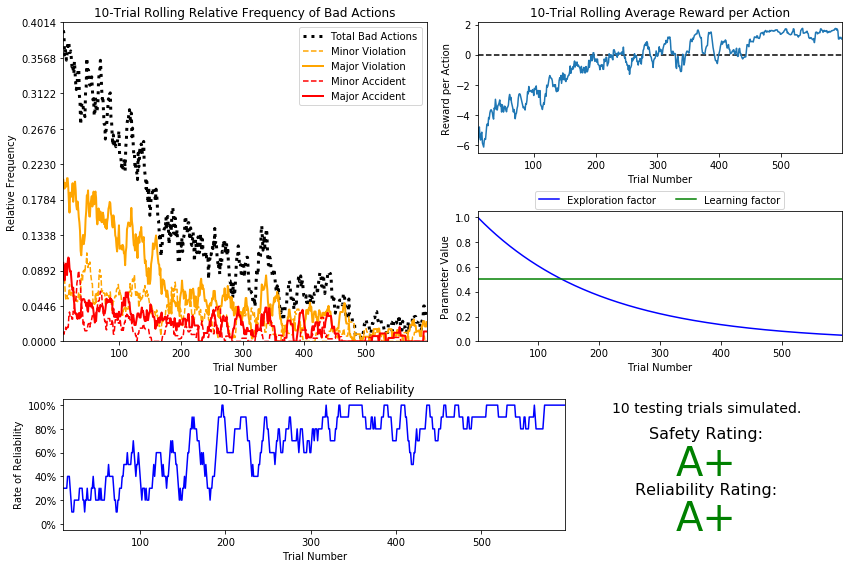

In [3]:
# Load the 'sim_improved-learning' file from the improved Q-Learning simulation
vs.plot_trials('sim_improved-learning.csv')

### 问题7
利用上面的从你改进的Q-Learning模拟中得到的可视化结果，像在**问题6**那样，给出关于改进的驾驶代理程序的最终分析和观察。你需要回答的问题：
- *使用了什么epsilon（探索因子）的衰减函数？*
- *在测试之前驾驶代理大约需要做多少训练试验？*
- *你用了什么epsilon-tolerance和alpha（学习率）值？为什么？*
- *与之前的默认Q-Learning学习器相比，这个Q-Learning学习器有多少改进？ *
- *你会说Q-Learning学习器的结果表明了你的驾驶代理程序成功地学习了一个合适的策略吗？*
- *你对*智能出租车*的安全性和可靠性评分满意吗？*

**回答：**

问：使用了什么epsilon（探索因子）的衰减函数？  
答：使用的衰减函数是 $\varepsilon = 0.995^{Trial ~ Count}$

问：在测试之前驾驶代理大约需要做多少训练试验？  
答：600轮训练试验。

问：你用了什么epsilon-tolerance和alpha（学习率）值？为什么？  
答：训练部分让epsilon从1下降至0.05。alpha选为0.5。
- epsilon下降的速率将决定训练轮数的多少以及探索强度的减弱速度。
  - 如果epsilon很快衰减到tolerance，那么训练轮数将只有几十轮，连Q-Table的所有状态都来不及训练齐，小车的驾驶水平将会比较低。
  - 如果epsilon初始值就很小，那么就意味着探索的强度将会一直很弱（即不随机驾驶、不试错），并且越来越弱，这对于刚开始训练还仿佛是一个婴儿的小车来说是不利的，此时的Q-Table收集的状态还很少，且绝大多数状态的操作值都是0，如果在这种状态就让小车经常从Q值表里取最佳方案，取出来的其实没有任何价值，因此小车的驾驶水平将会始终很低。  


为了确保小车学到尽可能多的东西，应该让epsilon从1开始缓慢下降。用上面列出的任何一个衰减函数其实都差不多，核心思想是只要确保Training Trials次数足够多，Q-Table足够丰满就行。

- alpha决定了更新同一状态Q值时，对新奖励的偏好程度，值越接近1越看重新数据。（由以下代码分析可得）
  - 如果alpha = 0.5，就说明学习策略对新reward和表中存的旧reward一视同仁。随着更新次数趋近于无穷，最早的非零reward对Q值的影响趋近于0，离更新越近的reward对Q值影响越大，最新的reward对Q值的影响占50%。
  - 如果alpha = 0.1，就说明学习策略对旧reward更为看重。不过随着更新次数趋近于无穷，最早的非零reward的影响力也将趋近于0，而最新的reward对Q值的影响占10%。
  - 如果alpha = 0.9，就说明学习策略对新reward更为看重。最新的reward对Q值的影响始终占90%。
  - 特殊的，如果alpha = 0，就相当于完全停止学习，停止接受新的数据，Q-Table中的任何值都会保持原样。我们仅会在测试模型性能时才需要把alpha设为0.
    
```python
def learn(self, state, action, reward):
   prev_Q = self.Q[state][action]
   self.Q[state][action] = prev_Q * (1 - self.alpha) + reward * self.alpha
```

尝试了不同的alpha值，实验结果显示，只要训练轮数够多，alpha大小其实对最终的测试结果影响并不大，都能得双A+。这背后的原因在于environment.py 中制定的奖励机制。由于奖励值在每个状态下只是一个在很小范围内均匀分布的值，因此不管你更新同一个状态多少次，都不会比之前遇到过的奖励值差太多，因此偏好程度就没有那么大的影响力。
例如从log中可以看到，对于状态 (light='red', oncoming=None, left='forward', right=None, waypoint='right') 来说，这个状态描述的就是一个红灯要右转且左侧有来车的情形，此时执行forward操作的平均奖励是-40.26。其实无论遇到多少次这种状态，对应的奖励都应该是-40左右，因此是否偏好新数据并不是特别重要，只要不是0就行。可以说，alpha的影响力没有epsilon那么大。

问：与之前的默认Q-Learning学习器相比，这个Q-Learning学习器有多少改进？
答：与之前默认的agent相比，目前的agent驾驶水平改经了很多。
- 训练次数从原有的20次提升至600次。
- 随着训练次数的提高，各项bad action的频率逐渐降低至0，
- 平均reward则逐渐上升至+2
- 可靠性也达到了90%-100%附近。
- 小车的整体评分可以在多次执行下维持在双A+或者安全性A+/可靠性A的状态（即偶尔会有1次抵达不了目的地）。

问：你会说Q-Learning学习器的结果表明了你的驾驶代理程序成功地学习了一个合适的策略吗？  
答：通过上述结果分析，我觉得驾驶代理程序成功地学习了一个合适的策略。

问：你对智能出租车的安全性和可靠性评分满意吗？  
答：我对此结果满意。我通过在learn()函数中加入对Q-Table学习情况的状态跟踪，可以看到训练时Q-Table的填满过程，以及训练终止时最终的学习状态。
```python
if prev_Q == 0 and reward != 0:
    self.state_action_count += 1
print 'Trial Count =', self.trial_count
print 'Q-Table Size = {} / {}'.format(len(self.Q), self.overall_states)
print 'Q-Table Non-zero Item Count = {} / {}'.format(self.state_action_count, self.overall_state_action)
```
输出结果  
Trial Count = 598  
Q-Table Size = 370 / 384  
Q-Table Non-zero Item Count = 1014 / 1536  

可以看到，经过600轮的训练，Q值表能够达到 384中的370个状态（覆盖率96%），以及 1536中的1014个状态-动作组合（覆盖率66%）。且在多次尝试下能保证性能稳定。这说明小车已经学到了整个世界的66%左右。

### 定义一个最优策略

有时，对于重要的问题*“我要让我的代理程序学习什么？”*的答案，只是理论性的，无法具体描述。然而这里，你可以具体定义代理程序要学什么，就是美国通行权交通法案。这些法律是已知信息，你可以基于这些法律，为*智能出租车*进一步定义每一个状态所做的最优动作。在那种情况下，我们称这一系列最优状态-动作配对为**最优策略**。因此，不像那些理论性的回答，不仅通过收到的奖励（惩罚），而且纯观察，代理程序是否在“错误”地行动能很清晰地得知。如果代理程序闯了红灯，我们既看见它获得了一个负面奖励，也知道这是一个错误的行为。这可以用来帮你验证驾驶代理程序习得的**策略**是否正确，或只是个**次优策略**。

### 问题 8
给出几个关于最优策略是什么样子的例子（用你已定义的状态）。之后，查看`'sim_improved-learning.txt'`文本文件，看你的改进的Q-Learning算法的结果。_每个从模拟中纪录的状态，对于给定的状态，**策略**（得分最高的动作）是否正确？是否对于有些状态，有策略不同于预期的最优策略？_给出一个状态和记录的状态-动作的奖励，解释为什么正是个正确的策略。

**回答：** 

宏观上的最佳策略是智能车如何达到目的地，这跟我们每天出行是一样的。在每个路口，由于车辆和红绿灯的不同，我们会采取不同的行动，但我们采取不同行动的目的是唯一的。我们训练智能车，应该不仅仅希望它在不同的路口选择正确的行动，遵守交规，不违章，更需要它能够“把握”自己的大方向，随机应变，“智能”地接近目的地。导航只能提供不考虑交通情况的最优路线，而最优策略则是在导航的基础上，结合当前所处的交通状态，判断是否应该听导航的。而这个判断依据，就是之前探索的时候收集到的最优解。对Q-Learning来说，最优策略的实体就是Q-Table，学习最优策略的过程就是探索的过程（Exploration），用最优策略驾驶就是利用的过程（Exploitation）。

- 推荐策略与最优策略示例1：
  - 状态：导航提示要直行，但现在遇到了红灯，且左侧即将有直行车辆通过。
  - 最优策略：等灯。

```python
(light='red', oncoming=None, left='forward', right=None, waypoint='forward')
 -- forward : -39.67
 -- None : 1.98
 -- right : -17.49
 -- left : -37.82
 ```
 
上面是Q-Table中的相应状态的Q值数据，可以看到唯一是正值的操作就是None，也就是原地等灯。这与实际最优策略相匹配。另外对于其他几种操作的奖励也很有道理，在这种情况下左转和直行的惩罚都相当严重（-39和-37），这是因为这么做会与左侧直行车辆相撞，造成重大交通事故；右转的惩罚也不小（-17），因为这么做会与左侧车道的车辆造成交通事故。

- 推荐策略最优策略实例2：
  - 状态：导航提示要左转，现在是绿灯，但是对向车道有即将有直行车辆通过。
  - 最优策略：进入路口，但是先不左转，等对向车通过后再左转。
  
```python
(light='green', oncoming='forward', left=None, right=None, waypoint='left')
 -- forward : 0.33
 -- None : -4.62
 -- right : 0.69
 -- left : -19.93
```

可以看到Q值表相应的状态的left操作奖励是-19，而right操作却具有最高的奖励值0.69。这与最优策略显然不同。不过原因在于这个世界里没有左转待转这个行为，因为每辆车只要进入路口，都只能呆1个时间slot，没有等待对向车通过的这个时间粒度。所以为了避免绿灯左转遇到交通事故，右转或者直行都是不错的选项。

- Q-table提供的策略是次最优策略的情况：在训练次数不够的时候遇到过。造成这种情况的原因通常都是因为原本真正的最佳策略还没有尝试过，因此依然是初始值，而刚好此时已经有一个次最优操作已经尝试过，有大于0的值，因此导致Q-table推荐的是次最优策略。

例如：绿灯需要直行，由于所有其他车都守规矩，显然应该直接直行。但是下面Q-Table中推荐的最优策略却是right。这是因为forward目前还是0.00，等到训练的次数多了，随机到了选forward作为action后，就知道其Q值应该是2左右，大于right的0.60。所以Q值表推荐次最优策略的根本原因就是随机试错的还不够多，遇到这种情况，只要增加训练次数就OK了。

```python
(light='green', oncoming='None', left='left', right=None, waypoint='forward')
 -- forward : 0.00
 -- None : -5.12
 -- right : 0.60
 -- left : 1.04
```



-----
### 选做：未来奖励 - 折扣因子 `'gamma'`
也许你会好奇，作为Q-Learning算法的一部分，之前要求你在实现中**不要**使用折扣引子`'gamma'`。在算法中包含未来奖励能有助于在未来状态回溯到当前状态时的反向正面奖励。本质上，如果给予驾驶代理程序执行若干动作到达不同状态的选择，包含未来奖励会是代理程序偏向可以得到更多奖励的状态。一个例子是驶向目的的驾驶代理程序：所有行动和奖励都相等，那么理论上如果到达目的地会有额外奖励，驶向目的会获得更好的奖励。然而，即使在这个项目里，驾驶代理程序也要在规定的时间里到达目的地，包含未来奖励不会有益于代理程序。实际上，如果代理程序给予多次试验学习，它甚至会给Q-value带来负面影响！

### 可选问题 9
*在项目中有两个特点使得未来奖励在这个Q-Learning算法无效。一个特点是关于*智能出租车*本身，另一个是关于环境。你能指出它们是什么以及为什么未来奖励不会在这个项目中起效？*

**回答：**

- 智能车知道目的地的大方向，但它在行驶过程中并不知道离目的地有多远。过大的回溯操作容易造成路径依赖。
- 如果起点和终点固定，未来奖励会随着智能车学习逐渐从目的地“扩散”到起点。我们的训练环境里，起点和终点并不固定而是随机的。这使得每次训练的场景都与上次不同，而不同场景的路线奖励是不能通用的。只有在起点和终点始终固定的情况下，未来奖励才能促进学习。

> **注意**:当你写完了所有的代码，并且回答了所有的问题。你就可以把你的 iPython Notebook 导出成 HTML 文件。你可以在菜单栏，这样导出**File -> Download as -> HTML (.html)**把这个 HTML 和这个 iPython notebook 一起做为你的作业提交。